In [1]:
import numpy as np
import lz4.frame
import matplotlib.pyplot as plt

In [205]:
if False:  # unit test
    for nbits in (8, 16, 32):
        scale = min(2**(nbits-1), 2**23)
        d = np.arange(-(scale-1), scale, dtype=f'int{nbits}')
        ig = degray(gray(d, nbits=nbits), nbits=nbits)
        assert np.all(d == ig)

    for nbits in (8, 16, 32):
        scale = min(2**(nbits-1), 2**15)
        d = np.arange(-scale, scale, dtype=f'int{nbits}')
        ib = debitshuffle(bitshuffle(d, nbits=nbits), nbits=nbits, dtype='int')
        assert np.all(d == ib)

In [982]:
# remove -2**(nbits-1) as a supported number

def _gray(b, nbits):
    neg = np.where(b < 0)
    ab = np.abs(b).astype(f'uint{nbits}')
    g = ab ^ (ab >> 1)
    g <<= 1
    g[b < 0] |= 1
    return g


def _degray(b, nbits):
    neg = b & 1
    b >>= 1
    for i in range(int(np.log2(nbits))):
        b ^= (b >> 2**i)
    b = b.astype(f'int{nbits}')
    b = np.where(neg, -b, b)
    return b
    

def _get_used_bits(b, nbits):
    m = np.bitwise_or.reduce(b).view(f'uint{nbits}')
    return int(np.ceil(np.log2(m + 1)))


def _bitshuffle(d, nbits):
    scalar = 2**np.arange(nbits)
    scalar.shape = (1, nbits)
    out = []
    for i in range(nbits):
        buf = (d >> (nbits - i -1)) & 1
        buf.shape = (-1, nbits)
        buf = np.sum(buf * scalar, axis=1, keepdims=True)
        out.append(buf)
    out = np.concatenate(out, axis=0).flatten()
    return out.astype(f'uint{nbits}')


def _debitshuffle(d, nbits, dtype='uint'):
    out = []
    scalar = 2**np.arange(nbits)[::-1]
    scalar.shape = (1, nbits)
    stride = d.shape[0] // nbits
    for b in [d[j::stride] for j in range(stride)]:
        for i in range(nbits):
            buf = (b >> i) & 1
            buf.shape = (-1, nbits)
            buf = np.sum(buf * scalar, axis=1, keepdims=True)
            out.append(buf)
    out = np.concatenate(out, axis=0).flatten()
    return out.astype(f'{dtype}{nbits}')


def _rot_encode(d, rotm, rescale=2**5, dtype_out=None):
    if dtype_out is None:
        nbits = d.dtype.itemsize * 8
        dtype_out = f'int{nbits*2}'
    d = np.around(np.dot(d.reshape(-1, rotm.shape[0]), rotm) / rescale).astype(dtype_out)
    return d.T.flatten()


def _rot_decode(d, irotm, rescale=2**5):
    d = np.around(np.dot(d.reshape(irotm.shape[0], -1).T, irotm) * rescale).flatten()
    return d


def _block_compress(d, nbits, gray=True, bitshuffle=True, mode='cust'):
    if gray:
        d = _gray(d, nbits)
    if mode == 'cust':
        assert bitshuffle
        assert gray
        m = _get_used_bits(d, nbits)
        d = np.pad(_bitshuffle(d, nbits), (1, 0))[-m * d.shape[0] // nbits - 1:]
        d[0] = m
    else:
        if bitshuffle:
            d = _bitshuffle(d, nbits)
    return d
        
        
def _block_decompress(d, nbits, block, gray=True, bitshuffle=True, mode='lz4'):
    if mode == 'cust':
        assert bitshuffle
        d = np.pad(d, (block-d.shape[0], 0))
    elif mode == 'lz4':
        #d = lz4.frame.decompress(d)
        pass  # decode later
    else:
        raise ValueError(f'Unrecognized mode: {mode}')
    if bitshuffle:
        d = _debitshuffle(d, nbits)
    if gray:
        d = _degray(d, nbits)
    return d
        
        
def _split_cust_blocks(d, nbits, block):
    i = 0
    while i < d.shape[0]:
        m = d[i]
        j = i + 1 + m * block // nbits
        yield d[i+1:j]
        i = j
    return


def compress(d, gray=True, bitshuffle=True, mode='lz4', rotm=None, block=256, rescale=2**6, nbits=None, dtype_out=None):
    if nbits is None:
        nbits = 8 * d.dtype.itemsize
    if rotm is not None:
        if dtype_out is None:
            dtype_out = f'int{2*nbits}'
            nbits *= 2
        d = rot_encode(d, rotm, rescale=rescale).astype(dtype_out)
    buf = [_block_compress(d[i:i+block], nbits, gray=gray, bitshuffle=bitshuffle, mode=mode)
           for i in range(0, d.shape[0], block)]
    buf = np.concatenate(buf)
    if mode == 'lz4':
        return lz4.frame.compress(buf)
    elif mode == 'cust':
        return buf.tobytes()
    else:
        raise ValueError(f'Unrecognized mode: {mode}')
    

def decompress(d, nbits, gray=True, bitshuffle=True, mode='lz4', irotm=None, block=256, rescale=2**6, dtype_out=None):
    dtype = f'uint{nbits}'
    # XXX could be int if lz4 and not gray or bitshuffle
    if dtype_out is None:
        dtype_out = f'int{nbits}'
    if mode == 'lz4':
        d = np.frombuffer(lz4.frame.decompress(d), dtype=dtype).copy()
        buf = [d[i:i+block] for i in range(0, d.shape[0], block)]
    elif mode == 'cust':
        d = np.frombuffer(d, dtype=dtype)
        buf = _split_cust_blocks(d, nbits, block)
    else:
        raise ValueError(f'Unrecognized mode: {mode}')
    d = np.concatenate([_block_decompress(b, nbits, block, gray=gray, bitshuffle=bitshuffle, mode=mode)
                        for b in buf])
    if irotm is not None:
        d = _rot_decode(d, irotm, rescale=rescale)
    d = d.astype(dtype_out)
    return d


def est_rot_matrix(n, dim=8, rescale=2**6, dtype='int16'):
    n = n[:n.size - n.size % dim].reshape(-1, dim).astype(float)
    cov = np.dot(n.T, n)
    U, _, _ = np.linalg.svd(cov, hermitian=True)
    Ur = np.around(U * rescale)
    iUr = np.linalg.inv(Ur)
    return Ur.astype(dtype), iUr
    

def gen_noise(scale, cen=0, size=1024, dtype='int8'):
    nbits = 8 * np.dtype(dtype).itemsize
    n = np.random.normal(loc=cen, scale=scale, size=size)
    # remove -2**(nbits-1) as a supported number
    n = np.around(n).clip(-2**(nbits-1)+1, 2**(nbits-1)-1).astype(dtype)
    return n


def gen_sine(scale, period, cen=0, size=1024, phs0=1, dtype='int8'):
    nbits = 8 * np.dtype(dtype).itemsize
    n = scale * np.sin(2*np.pi * np.arange(size) / period + phs0) + cen
    # remove -2**(nbits-1) as a supported number
    n = np.around(n).clip(-2**(nbits-1)+1, 2**(nbits-1)-1).astype(dtype)
    return n


def calc_size(b):
    if type(b) in (str, bytes):
        return len(b)
    else:
        return b.size * b.dtype.itemsize
    
    
def view_binimg(d):
    nbits = d.dtype.itemsize * 8
    bits = np.array([(d >> i) & 1 for i in range(nbits)])
    return bits

<IPython.core.display.Javascript object>


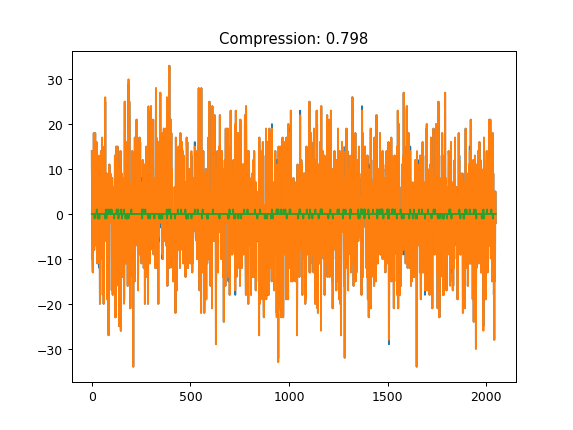

In [987]:
dtype = 'int8'
SIZE = 2048
GRAY, BS, MODE, ROT = True, True, 'lz4', True

d = gen_noise(10., size=SIZE, dtype=dtype)
nbits = 8 * np.dtype(dtype).itemsize
if ROT:
    rotm, irotm = est_rot_matrix(d, dim=16)
    nbits *= 2
else:
    rotm, irotm = None, None

b = compress(d, rotm=rotm, gray=GRAY, bitshuffle=BS, mode=MODE)
d_r = decompress(b, nbits=nbits, irotm=irotm, gray=GRAY, bitshuffle=BS, mode=MODE)

plt.figure()
plt.title(f'Compression: {calc_size(b) / calc_size(d):5.3f}')
plt.plot(d)
plt.plot(d_r)
plt.plot(d - d_r)

In [868]:
if False:
    plt.figure()
    noise = gen_noise(8, cen=0, size=8192, dtype='int8')
    hist, bins = np.histogram(noise, bins=2**8)
    _ = plt.plot(0.5 * (bins[:-1] + bins[1:]), hist)
    #plt.xlim(-32, 32)
    plt.ylim(0, hist.max())

In [1058]:
NAVG = 50
SIZE = 2048
dtype = 'int8'
SIN_SCALE = 0
NOS_SCALE = 1.1
BLOCK = 256
#BLOCK = 64

d = gen_sine(SIN_SCALE, period=4.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(NOS_SCALE, size=SIZE, dtype=dtype)
rotm8, irotm8 = est_rot_matrix(n, dim=8)
rotm16, irotm16 = est_rot_matrix(n, dim=16)

modes = [
    {'mode':'cust', 'gray':True, 'bitshuffle':True, 'rotm':None, 'block':BLOCK},
    {'mode':'cust', 'gray':True, 'bitshuffle':True, 'rotm':rotm8, 'block':BLOCK},
    #{'mode':'cust', 'gray':True, 'bitshuffle':True, 'rotm':rotm16, 'block':BLOCK},
    #{'mode':'lz4',  'gray':True, 'bitshuffle':True, 'rotm':None, 'block':BLOCK},
    {'mode':'lz4',  'gray':False,'bitshuffle':True, 'rotm':None, 'block':BLOCK},
    {'mode':'lz4',  'gray':False,'bitshuffle':False,'rotm':None, 'block':BLOCK},
    {'mode':'lz4',  'gray':True, 'bitshuffle':True, 'rotm':rotm8, 'block':BLOCK},
    #{'mode':'lz4',  'gray':False,'bitshuffle':True, 'rotm':rotm16, 'block':BLOCK},
]

def mode_str(m):
    try:
        dim = m['rotm'].shape[0]
    except(AttributeError):
        dim=0
    return f"{m['mode'][:3]},{'g' if m['gray'] else '-'}{'b' if m['bitshuffle'] else '-'},{dim:02d}"

ans = {mode_str(m): {} for m in modes}
for scale in 2.0**np.arange(-1, 5):
    print(scale)
    for _ in range(NAVG):
        #d = gen_sine(SIN_SCALE, period=2.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(NOS_SCALE, size=SIZE, dtype=dtype)
        d = gen_sine(SIN_SCALE, period=2.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(scale, size=SIZE, dtype=dtype)
        size0 = calc_size(d)
        for m in modes:
            key = mode_str(m)
            ans[key][scale] = ans[key].get(scale, []) + [calc_size(compress(d, **m)) / size0]
            
for m in modes:
    key = mode_str(m)
    for scale in ans[key]:
        ans[key][scale] = np.mean(ans[key][scale])

0.5
1.0
2.0
4.0
8.0
16.0


<IPython.core.display.Javascript object>


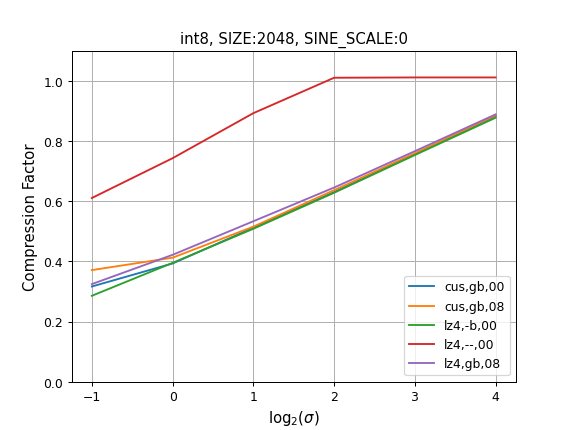

In [1059]:
plt.figure()
for key, dat in ans.items():
    plt.plot(np.log2(list(ans[key].keys())), ans[key].values(), label=key)
plt.title(f'{dtype}, SIZE:{SIZE}, SINE_SCALE:{SIN_SCALE}')
plt.ylim(0., 1.1)
plt.xlabel(r'${\rm log}_2(\sigma)$', fontsize=12)
plt.ylabel('Compression Factor', fontsize=12)
plt.legend(loc='best')
plt.grid()

<IPython.core.display.Javascript object>


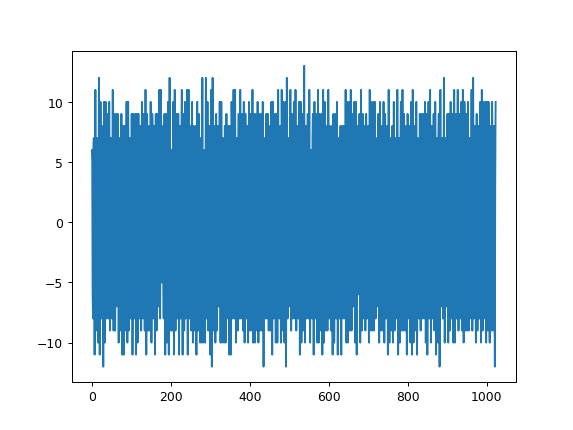

In [1064]:
#print(np.abs(gen_noise(1, size=256, dtype='int8')).max())
d = gen_sine(10, size=1024, period=4.37) + gen_noise(1, size=1024, dtype='int8')
plt.figure()
plt.plot(d)

In [999]:
NAVG = 50
SIZE = 2048
dtype = 'int8'
SIN_SCALE = 10
NOS_SCALE = 1.1

d = gen_sine(SIN_SCALE, period=4.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(NOS_SCALE, size=SIZE, dtype=dtype)
rotm8, irotm8 = est_rot_matrix(n, dim=8)
rotm16, irotm16 = est_rot_matrix(n, dim=16)

modes = [
    {'mode':'cust', 'gray':True, 'bitshuffle':True, 'rotm':None, 'block':BLOCK},
    {'mode':'cust', 'gray':True, 'bitshuffle':True, 'rotm':rotm8, 'block':BLOCK},
    #{'mode':'cust', 'gray':True, 'bitshuffle':True, 'rotm':rotm16, 'block':BLOCK},
    #{'mode':'lz4',  'gray':True, 'bitshuffle':True, 'rotm':None, 'block':BLOCK},
    {'mode':'lz4',  'gray':False,'bitshuffle':True, 'rotm':None, 'block':BLOCK},
    {'mode':'lz4',  'gray':False,'bitshuffle':False,'rotm':None, 'block':BLOCK},
    {'mode':'lz4',  'gray':True, 'bitshuffle':True, 'rotm':rotm8, 'block':BLOCK},
    #{'mode':'lz4',  'gray':False,'bitshuffle':True, 'rotm':rotm16, 'block':BLOCK},
]

def mode_str(m):
    try:
        dim = m['rotm'].shape[0]
    except(AttributeError):
        dim=0
    return f"{m['mode'][:3]},{'g' if m['gray'] else '-'}{'b' if m['bitshuffle'] else '-'},{dim:02d}"

ans = {mode_str(m): {} for m in modes}
for scale in 2.0**np.arange(-1, 5):
    print(scale)
    for _ in range(NAVG):
        #d = gen_sine(SIN_SCALE, period=2.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(NOS_SCALE, size=SIZE, dtype=dtype)
        d = gen_sine(SIN_SCALE, period=2.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(scale, size=SIZE, dtype=dtype)
        size0 = calc_size(d)
        for m in modes:
            key = mode_str(m)
            ans[key][scale] = ans[key].get(scale, []) + [calc_size(compress(d, **m)) / size0]
            
for m in modes:
    key = mode_str(m)
    for scale in ans[key]:
        ans[key][scale] = np.mean(ans[key][scale])

0.5
1.0
2.0
4.0
8.0
16.0


<IPython.core.display.Javascript object>


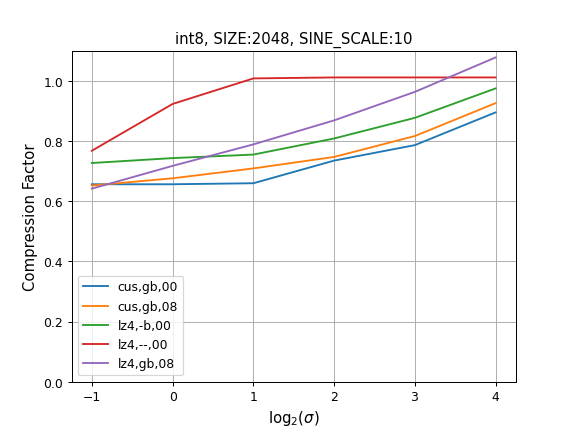

In [1000]:
plt.figure()
for key, dat in ans.items():
    plt.plot(np.log2(list(ans[key].keys())), ans[key].values(), label=key)
plt.title(f'{dtype}, SIZE:{SIZE}, SINE_SCALE:{SIN_SCALE}')
plt.ylim(0., 1.1)
plt.xlabel(r'${\rm log}_2(\sigma)$', fontsize=12)
plt.ylabel('Compression Factor', fontsize=12)
plt.legend(loc='best')
plt.grid()

<IPython.core.display.Javascript object>


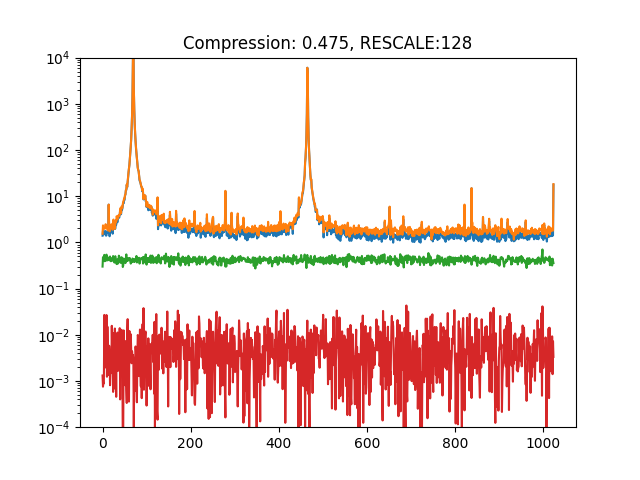

(0.0001, 10000.0)

In [1085]:
CNT = 64
RESCALE = 2**7
d = [gen_sine(10, period=29.4, cen=0, size=SIZE, dtype=dtype) + gen_sine(5, period=4.4, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
     for i in range(CNT)]
rotm, irotm = est_rot_matrix(d[0], dim=8)

b = [compress(d[i], mode='cust', bitshuffle=True, gray=True, rotm=rotm, rescale=RESCALE)
     for i in range(CNT)]
d_r = [decompress(b[i], 16, mode='cust', bitshuffle=True, gray=True, irotm=irotm, rescale=RESCALE)
       for i in range(CNT)]

d = np.array(d)
d_r = np.array(d_r)

plt.figure()
plt.title(f'Compression: {np.mean([calc_size(b[i]) / calc_size(d[i]) for i in range(CNT)]):5.3f}, RESCALE:{RESCALE}')
plt.semilogy(np.mean(np.abs(np.fft.rfft(d) / SIZE**0.5)**2, axis=0))
plt.semilogy(np.mean(np.abs(np.fft.rfft(d_r) / SIZE**0.5)**2, axis=0))
plt.semilogy(np.mean(np.abs(np.fft.rfft(d - d_r) / SIZE**0.5)**2, axis=0))
plt.semilogy(np.abs(np.mean(np.fft.rfft(d - d_r) / SIZE**0.5, axis=0))**2)
plt.ylim(1e-4, 1e4)

In [515]:
#noise = gen_noise(scale=227, dtype='int8')
SCALE = 30
dtype = 'int8'
SIZE = 1024
noise = gen_sine(SCALE, period=20.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(0.1, size=SIZE, dtype=dtype)
nbits = 8 * noise.dtype.itemsize

In [1001]:
DIM = 8
n = noise.reshape(-1, DIM)
cov = np.dot(n.T.astype(float), n.astype(float))
U, _, _ = np.linalg.svd(cov, hermitian=True)
for i in np.arange(2, 9):
    Ur = np.around(U * 2**i)
    print(i, np.max(np.abs(Ur)), np.std(np.dot(n, Ur), axis=0) / 2**i)

2 3.0 [39.94907465 16.95866932 13.76610492 14.09960488  2.30779385  2.73173823
  5.43386193  3.15297779]
3 5.0 [59.92361197 22.62646067 14.11194405 14.07715762  2.45988922  2.31412588
  1.57778625  1.53203944]
4 11.0 [57.64778444 22.37854964 13.78879142 13.27664313  2.27379131  1.45041295
  1.38057308  1.22217428]
5 22.0 [56.39487925 21.70848646 13.70179402 12.89433334  1.56394094  1.71994255
  1.20938937  1.29615681]
6 43.0 [57.26564162 21.57284414 13.77050442 13.13123602  1.38315874  1.28616734
  1.30307313  1.16207283]
7 87.0 [56.34162987 21.55756964 13.72651116 13.15228603  1.36854562  1.27186529
  1.20887527  1.14783097]
8 173.0 [56.56961469 21.66774788 13.7101767  13.12334525  1.37369328  1.26864631
  1.18461624  1.14832275]


In [1002]:
DIM = 16
n = noise.reshape(-1, DIM)
cov = np.dot(n.T.astype(float), n.astype(float))
U, _, _ = np.linalg.svd(cov, hermitian=True)
Ur = np.around(U * 2**6)
iUr = np.linalg.inv(Ur)

for i in np.arange(0, 10):
    nr = np.around(np.dot(n, Ur) / 2.0**i)
    n2 = np.dot(nr, iUr) * 2.0**i
    print(i, np.std(n.flatten() - n2.flatten()))

0 1.4526879408345292e-14
1 0.011056854965106853
2 0.01939655806126394
3 0.036755562277942376
4 0.07257807254067614
5 0.14356812043655404
6 0.291631793039137
7 0.5736551163177941
8 1.0650312715967825
9 1.5516242171264671


0.90625 0.69140625
0.81689453125 0.66015625
0.85693359375 0.64501953125
1.01123046875 1.56201171875
False


<IPython.core.display.Javascript object>


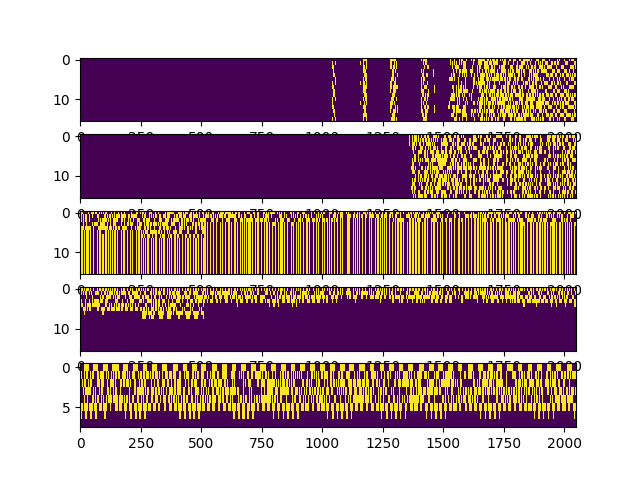

In [818]:
dtype = 'int8'
nbits = 8 * noise.dtype.itemsize
SIZE = 2048
#noise = gen_sine(100, period=4.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
noise = gen_sine(30, period=4.37, cen=0, size=SIZE, dtype=dtype) + gen_sine(10, period=40.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
Ur, iUr = est_rot_matrix(noise, dim=16)
#noise = gen_sine(10, period=4.37, phs0=0, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
noise = gen_sine(10, period=4.7, cen=0, size=SIZE, dtype=dtype) + gen_sine(30, period=40.7, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
nr = rot_encode(noise, Ur, rescale=2**6)
n2 = rot_decode(nr, iUr, rescale=2**6).astype(dtype)

#BLOCK = 256
BLOCK = 32
print(calc_size(compress_custom(noise, block=BLOCK))/SIZE, calc_size(compress_custom(noise, rotm=Ur, block=BLOCK))/SIZE)
print(calc_size(compress(noise))/SIZE, calc_size(compress(nr))/SIZE)
print(calc_size(compress_old(noise))/SIZE, calc_size(compress_old(nr))/SIZE)
print(calc_size(lz4.frame.compress(noise))/SIZE, calc_size(lz4.frame.compress(nr))/SIZE)
print(np.all(noise - n2 == 0))

plt.figure()
#plt.plot(nr)
#plt.plot(noise, alpha=0.5)
plt.subplot(511)
plt.imshow(view_binimg(bitshuffle(gray(nr))), aspect='auto', interpolation='nearest')
plt.subplot(512)
buf = np.zeros((16, SIZE))
ans = view_binimg(compress_custom(noise, rotm=Ur, block=64))
buf[:,-ans.shape[1]:] = ans
plt.imshow(buf, aspect='auto', interpolation='nearest')
plt.subplot(513)
plt.imshow(view_binimg(nr), aspect='auto', interpolation='nearest')
plt.subplot(514)
plt.imshow(view_binimg(gray(nr)), aspect='auto', interpolation='nearest')
plt.subplot(515)
plt.imshow(view_binimg(gray(noise)), aspect='auto', interpolation='nearest')
#plt.imshow(view_binimg(gray(nr)), aspect='auto', interpolation='nearest')

#plt.figure()
#plt.imshow(view_binimg(gray(noise)), aspect='auto', interpolation='nearest')
#
#if not np.all(noise - n2 == 0):
#    plt.figure()
#    plt.plot(noise)
#    plt.plot(n2)
#    plt.plot(noise - n2)

16
0.689453125
16


<IPython.core.display.Javascript object>


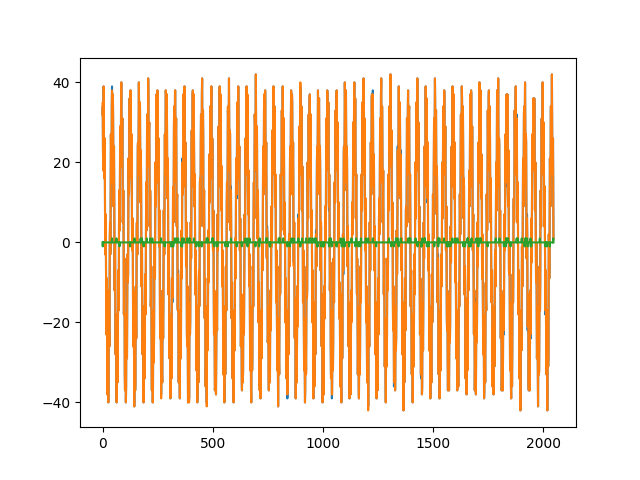

In [836]:
DIM = 8
dtype = 'int8'
nbits = 8 * noise.dtype.itemsize
SIZE = 2048
#noise = gen_sine(100, period=4.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
noise = gen_sine(30, period=4.37, cen=0, size=SIZE, dtype=dtype) + gen_sine(10, period=40.37, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
Ur, iUr = est_rot_matrix(noise, dim=16)
#noise = gen_sine(10, period=4.37, phs0=0, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
noise = gen_sine(10, period=4.7, cen=0, size=SIZE, dtype=dtype) + gen_sine(30, period=40.7, cen=0, size=SIZE, dtype=dtype) + gen_noise(1.1, size=SIZE, dtype=dtype)
BLOCK = 32
nr = compress_custom(noise, rotm=Ur, block=BLOCK)
print(calc_size(nr) / calc_size(noise))
n2 = decompress_custom(nr, irotm=iUr, block=BLOCK, dtype_out='int8')

plt.figure()
plt.plot(noise)
plt.plot(n2)
plt.plot(noise - n2)

<IPython.core.display.Javascript object>


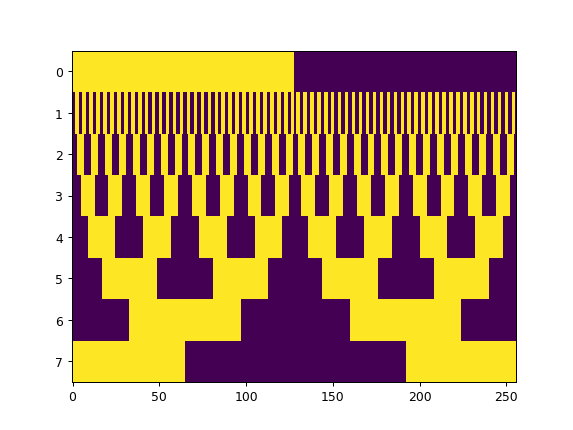

In [1044]:
if True:  # illustrate gray encoding
    plt.figure()
    plt.imshow(view_binimg(gray(np.arange(-128, 128).astype('int8'))), aspect='auto', interpolation='nearest')